In [13]:
!pip install xgboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random

pd.pandas.set_option('display.max_columns',None)

#Getting data from the csv
columns = [
    "Traffic_Type",        # Type of traffic use case (e.g., video streaming, gaming)
    "Device_Category",     # Category of the user device (LTE/5G UE)
    "Network",             # Supported technology (LTE/5G)
    "Day",                 # Day of the week (Monday, Tuesday, etc.)
    "Time",                # Time when data was recorded
    "GBR",                 # Minimum assured data rate (GBR)
    "Packet_Loss",         # Percentage of lost packets (Reliability)
    "Latency",             # Maximum allowable delay (Latency)
    "Network_Slice"        # Predicted slice type (eMBB, URLLC, mMTC)
]

df_en = pd.read_csv("input1.csv",names = columns,header = None)
df_en.drop(index=df_en.index[0], axis=0, inplace=True)
df_en.head()

In [70]:
for feature in df_en.columns:
    print(feature,df_en[feature].unique())
    print()

Traffic_Type ['Smartphone' 'IoT Devices' 'Smart Transportation' 'Industry 4.0'
 'AR/VR/Gaming' 'Healthcare' 'Public Safety/E911' 'Smart City & Home']

Device_Category ['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' 12 13 14 15 16 17 18 19 20 1 2 3 4 5 6 7 8 9 10 11
 '0' 'M1' 'NB-IoT']

Network ['LTE/5G' 'IoT (LTE-M, NB-IoT)']

Day ['Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday' 'Sunday']

Time ['1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '11' '12' '13' '14' '15' '16'
 '17' '18' '19' '20' '21' '22' '23' 5 6 7 8 9 10 11 12 13 14 15 16 17 18
 19 20 21 22 23 1 2 3 4]

GBR ['1' '2' '3' '4' '65' '66' '5' '6' '7' '8' '9' '69' '70' 3 4 65 66 5 6 7 8
 9 69 70 1 2]

Packet_Loss ['0.01' 0.01 0.001 1e-06]

Latency ['<50ms' '<300ms' '<10ms']

Network_Slice ['eMBB' 'mMTC' 'URLLC']



In [71]:
df_en["Network_Slice"].value_counts()

Network_Slice
URLLC    209300
mMTC     131859
eMBB     125580
Name: count, dtype: int64

In [72]:
df_en.shape

(466739, 9)

In [73]:
df_en.dtypes

Traffic_Type       object
Device_Category    object
Network            object
Day                object
Time               object
GBR                object
Packet_Loss        object
Latency            object
Network_Slice      object
dtype: object

In [74]:
df_low_latency = df_en[df_en["Latency"] == "<10ms"]
df_low_latency.sample(15)

,Traffic_Type,Device_Category,Network,Day,Time,GBR,Packet_Loss,Latency,Network_Slice
283019,Public Safety/E911,16,"IoT (LTE-M, NB-IoT)",Tuesday,13,7,0.000001,<10ms,URLLC
260986,Public Safety/E911,5,"IoT (LTE-M, NB-IoT)",Friday,20,9,0.000001,<10ms,URLLC
215356,Healthcare,3,"IoT (LTE-M, NB-IoT)",Sunday,6,9,0.000001,<10ms,URLLC
386655,AR/VR/Gaming,2,LTE/5G,Saturday,4,7,0.000001,<10ms,URLLC
277907,Public Safety/E911,13,"IoT (LTE-M, NB-IoT)",Saturday,11,66,0.000001,<10ms,URLLC
252058,Public Safety/E911,1,"IoT (LTE-M, NB-IoT)",Thursday,1,1,0.000001,<10ms,URLLC
246786,Healthcare,18,"IoT (LTE-M, NB-IoT)",Sunday,9,5,0.000001,<10ms,URLLC
414937,AR/VR/Gaming,16,LTE/5G,Tuesday,18,3,0.000001,<10ms,URLLC
441812,Industry 4.0,9,"IoT (LTE-M, NB-IoT)",Monday,15,5,0.000001,<10ms,URLLC
229139,Healthcare,10,"IoT (LTE-M, NB-IoT)",Thursday,9,1,0.000001,<10ms,URLLC


In [75]:
df_en = df_en.drop(columns=['Latency','Packet_Loss'],axis =1)

In [76]:
throughput_ranges = {
    "Smartphone": (10, 50),
    "IoT Devices": (0.5, 5),
    "Smart Transportation": (10, 30),
    "Industry 4.0": (5, 20),
    "AR/VR/Gaming": (40, 100),
    "Healthcare": (10, 30),
    "Public Safety/E911": (2, 10),
    "Smart City & Home": (5, 20)
}

latency_ranges = {
    "Smartphone": (20, 50),
    "IoT Devices": (100, 300),
    "Smart Transportation": (10, 30),
    "Industry 4.0": (1, 10),
    "AR/VR/Gaming": (5, 20),
    "Healthcare": (10, 30),
    "Public Safety/E911": (5, 20),
    "Smart City & Home": (30, 100)
}

packet_loss_ranges = {
    "Smartphone": (0.0001, 0.0005),
    "IoT Devices": (0.00001, 0.0001),
    "Smart Transportation": (0.0001, 0.0005),
    "Industry 4.0": (0.00001, 0.0001),
    "AR/VR/Gaming": (0.0001, 0.0005),
    "Healthcare": (0.00001, 0.0001),
    "Public Safety/E911": (0.0000001, 0.000001),
    "Smart City & Home": (0.00001, 0.0001)
}

def generate_packet_loss(traffic_type):
    if traffic_type in packet_loss_ranges:
        low, high = packet_loss_ranges[traffic_type]
        return random.uniform(low, high)
    return 0.0  # Default value if the traffic type is not found

def generate_latency(traffic_type):
    if traffic_type in latency_ranges:
        low, high = latency_ranges[traffic_type]
        return random.uniform(low, high)
    

def generate_expected_throughput(traffic_type):
    """
    Generate a random expected throughput value for a given traffic type.
    """
    if traffic_type in throughput_ranges:
        low, high = throughput_ranges[traffic_type]
        return round(random.uniform(low, high), 2)  # rounded for readability
    return None

df_en["Throughput"] = df_en["Traffic_Type"].apply(generate_expected_throughput)
df_en["Packet_Loss"] = df_en["Traffic_Type"].apply(generate_packet_loss)
df_en["Latency"] = df_en["Traffic_Type"].apply(generate_latency)

In [77]:
df_en = df_en.drop(columns=['Traffic_Type','Device_Category','Network'],axis =1)
df_en.head()

,Day,Time,GBR,Network_Slice,Throughput,Packet_Loss,Latency
1,Monday,1,1,eMBB,15.54,0.000363,48.499923
2,Monday,1,2,eMBB,29.46,0.000168,21.122542
3,Monday,1,3,eMBB,12.99,0.000235,21.981528
4,Monday,1,4,eMBB,41.93,0.000417,42.449500
5,Monday,1,65,eMBB,40.94,0.000499,45.307264


In [117]:
data = df_en.drop(columns=["Day","Time"])
data.head()

,GBR,Network_Slice,Throughput,Packet_Loss,Latency
1,1,eMBB,15.54,0.000363,48.499923
2,2,eMBB,29.46,0.000168,21.122542
3,3,eMBB,12.99,0.000235,21.981528
4,4,eMBB,41.93,0.000417,42.449500
5,65,eMBB,40.94,0.000499,45.307264


In [116]:
# Data Visualization

  GBR Network_Slice  Throughput  Packet_Loss    Latency
1   1          eMBB       15.54     0.000363  48.499923
2   2          eMBB       29.46     0.000168  21.122542
3   3          eMBB       12.99     0.000235  21.981528
4   4          eMBB       41.93     0.000417  42.449500
5  65          eMBB       40.94     0.000499  45.307264


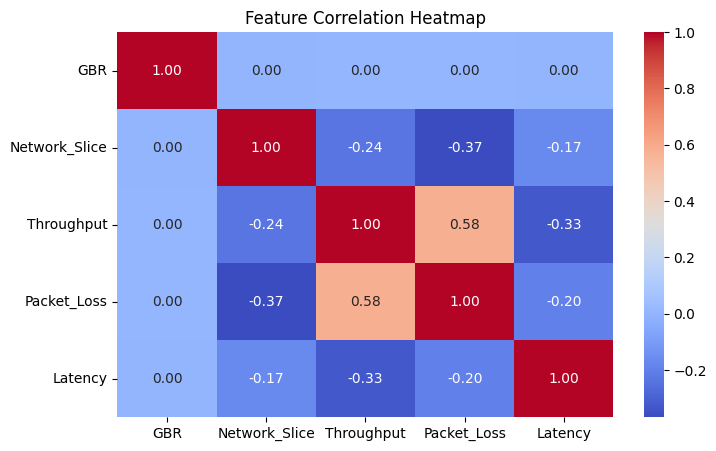

In [118]:
pred_nums = {
    "eMBB" : 0,
    "URLLC" :2,
    "mMTC":1
}

print(data.head())

data["Network_Slice"] = data["Network_Slice"].map(pred_nums)

# Now plot the heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


C:\Users\Ashok Adithya\AppData\Local\Temp\ipykernel_13060\1715998443.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Network_Slice", data=data, palette="viridis")


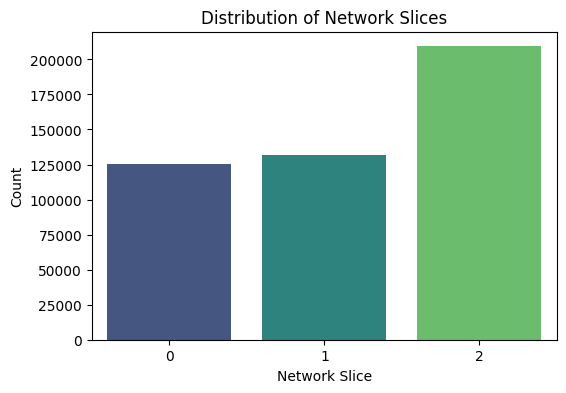

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.countplot(x="Network_Slice", data=data, palette="viridis")
plt.title("Distribution of Network Slices")
plt.xlabel("Network Slice")
plt.ylabel("Count")
plt.show()


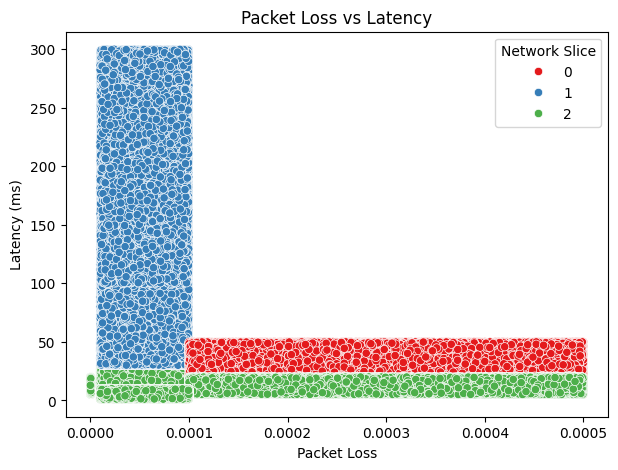

In [29]:
plt.figure(figsize=(7, 5))
sns.scatterplot(x="Packet_Loss", y="Latency", hue="Network_Slice", data=data, palette="Set1")
plt.title("Packet Loss vs Latency")
plt.xlabel("Packet Loss")
plt.ylabel("Latency (ms)")
plt.legend(title="Network Slice")
plt.show()


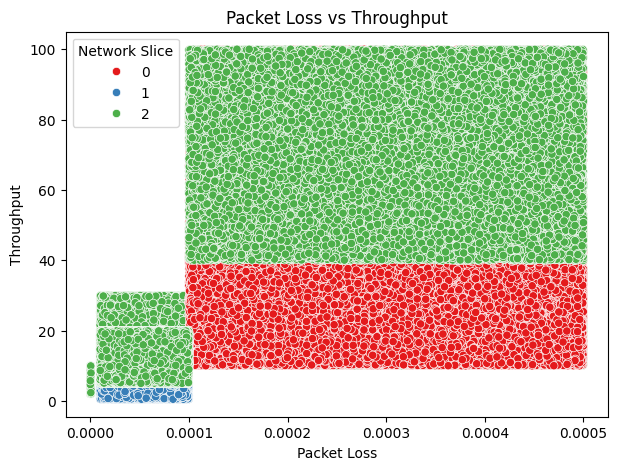

In [34]:
plt.figure(figsize=(7, 5))
sns.scatterplot(x="Packet_Loss", y="Throughput", hue="Network_Slice", data=data, palette="Set1")
plt.title("Packet Loss vs Throughput")
plt.xlabel("Packet Loss")
plt.ylabel("Throughput")
plt.legend(title="Network Slice")
plt.show()

C:\Users\Ashok Adithya\AppData\Local\Temp\ipykernel_13060\1170397454.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Network_Slice", y="Throughput", data=data, palette="coolwarm")


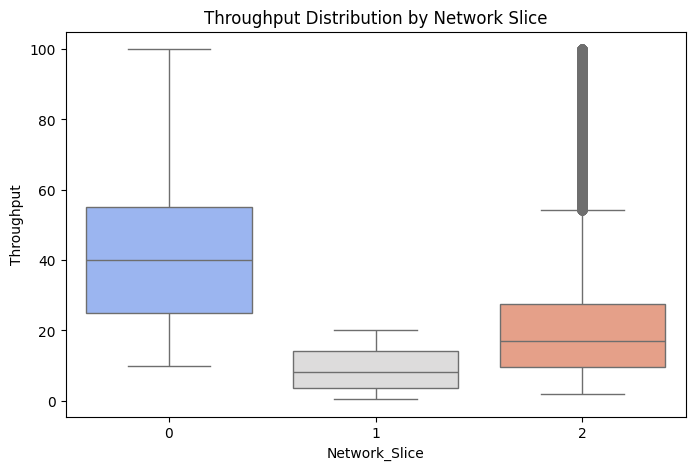

In [30]:
plt.figure(figsize=(8, 5))
sns.boxplot(x="Network_Slice", y="Throughput", data=data, palette="coolwarm")
plt.title("Throughput Distribution by Network Slice")
plt.show()


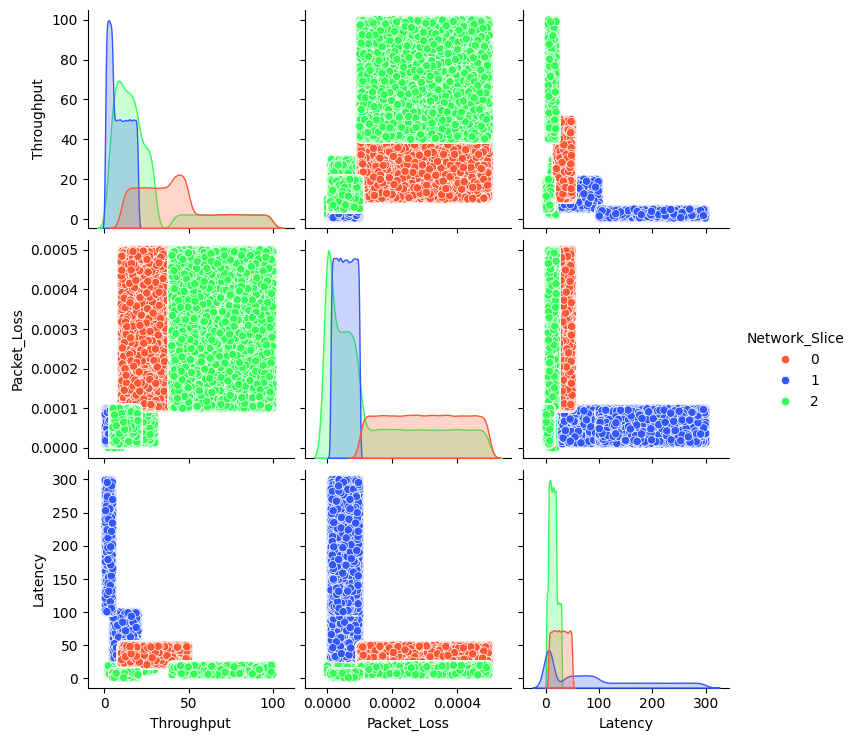

In [31]:
custom_palette = {0: "#FF5733", 2: "#33FF57", 1: "#3357FF"}

sns.pairplot(data, hue="Network_Slice", palette=custom_palette)
plt.show()

In [120]:
df_en = pd.get_dummies(df_en, columns=["Network_Slice"], prefix="Slice")
list1 =["Slice_URLLC","Slice_eMBB","Slice_mMTC"]
for i in list1:
    df_en[i] = df_en[i].astype(int)
df_en.sample(15)

,Day,Time,GBR,Throughput,Packet_Loss,Latency,Slice_URLLC,Slice_eMBB,Slice_mMTC
221282,Saturday,2,7,29.99,1.916359e-05,13.413463,1,0,0
398014,Tuesday,4,66,84.84,4.119943e-04,16.962897,1,0,0
64599,Sunday,2,2,4.32,2.561743e-05,272.857093,0,0,1
303508,Monday,2,8,17.94,3.474806e-05,90.084422,0,0,1
234166,Sunday,4,8,13.59,4.165095e-05,24.456065,1,0,0
24909,Sunday,8,1,39.79,2.695396e-04,22.482547,0,1,0
310903,Thursday,19,6,7.99,6.316927e-05,77.304483,0,0,1
25788,Wednesday,6,7,37.10,3.233269e-04,31.119523,0,1,0
284049,Friday,23,69,2.75,8.991597e-07,15.786989,1,0,0
116164,Thursday,12,7,28.00,2.331160e-04,13.354042,1,0,0


In [121]:
# We can remove GBR as no correcivity between slice and GBR found
X = df_en.drop(columns = ['Slice_URLLC','Slice_eMBB','Slice_mMTC','GBR','Day','Time'])
y = df_en[["Slice_URLLC","Slice_eMBB","Slice_mMTC"]]
X.head()

,Throughput,Packet_Loss,Latency
1,15.54,0.000363,48.499923
2,29.46,0.000168,21.122542
3,12.99,0.000235,21.981528
4,41.93,0.000417,42.449500
5,40.94,0.000499,45.307264


In [122]:
X['Packet_Loss'] = pd.to_numeric(X['Packet_Loss'], errors='coerce')

In [123]:
X.shape,y.shape

((466739, 3), (466739, 3))

# Using Random Forest

In [124]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report

# Standardize input features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (Stratified for better balance)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Initialize base RandomForest model
rf_base = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)

# Use MultiOutputClassifier to support multi-label classification
rf_model = MultiOutputClassifier(rf_base)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Calculate accuracy for each label separately
accuracy = accuracy_score(y_test, y_pred)

# Display results
print(f"Overall Accuracy: {accuracy * 100:.2f}%")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, zero_division=1))


Overall Accuracy: 77.39%

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.87      0.79     41860
           1       0.84      0.69      0.76     25116
           2       0.92      0.75      0.83     26372

   micro avg       0.79      0.79      0.79     93348
   macro avg       0.83      0.77      0.79     93348
weighted avg       0.81      0.79      0.79     93348
 samples avg       0.80      0.79      0.97     93348



In [125]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Normalize numerical features
en_scaler = StandardScaler()
X_scaled = en_scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42,stratify=y)

# Build ANN model for classification
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dense(3, activation='softmax')  # 3 neurons for Slice prediction
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_test, y_test))

# Evaluate model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Predict Network Slice for new data
sample_input = np.array([[30, 0.0005, 40]])  # Example input without Day and Time
sample_input_scaled = scaler.transform(sample_input)

prediction = model.predict(sample_input_scaled)
predicted_slice = np.argmax(prediction, axis=1)  # Get highest probability index

print(f"Predicted Slice: {predicted_slice}")


Epoch 1/25
11669/11669 [==============================] - 43s 4ms/step - loss: 0.3483 - accuracy: 0.7813 - val_loss: 0.3222 - val_accuracy: 0.7859
Epoch 2/25
11669/11669 [==============================] - 42s 4ms/step - loss: 0.3197 - accuracy: 0.7862 - val_loss: 0.3147 - val_accuracy: 0.7864
Epoch 3/25
11669/11669 [==============================] - 57s 5ms/step - loss: 0.3142 - accuracy: 0.7875 - val_loss: 0.3134 - val_accuracy: 0.7878
Epoch 4/25
11669/11669 [==============================] - 46s 4ms/step - loss: 0.3118 - accuracy: 0.7878 - val_loss: 0.3095 - val_accuracy: 0.7862
Epoch 5/25
11669/11669 [==============================] - 52s 4ms/step - loss: 0.3105 - accuracy: 0.7887 - val_loss: 0.3083 - val_accuracy: 0.7894
Epoch 6/25
11669/11669 [==============================] - 48s 4ms/step - loss: 0.3093 - accuracy: 0.7884 - val_loss: 0.3060 - val_accuracy: 0.7908
Epoch 7/25
11669/11669 [==============================] - 49s 4ms/step - loss: 0.3085 - accuracy: 0.7889 - val_loss: 0

C:\Users\Ashok Adithya\.conda\envs\tf_2_9\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


1/1 [==============================] - 3s 3s/step
Predicted Slice: [1]


In [126]:
#XGBOOST

import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Base XGBoost model
xgb_base = xgb.XGBClassifier(
    objective='binary:logistic',  # Since we use MultiOutputClassifier, keep binary target encoding
    eval_metric='logloss',  
    use_label_encoder=False,
    n_estimators=100,  
    max_depth=6,  
    learning_rate=0.1
)

# Multi-output wrapper for multi-label classification
model_xgb = MultiOutputClassifier(xgb_base)
model_xgb.fit(X_train, y_train)

# Predict
y_pred_xgb = model_xgb.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb, zero_division=1))


C:\Users\Ashok Adithya\.conda\envs\tf_2_9\lib\site-packages\xgboost\core.py:158: UserWarning: [22:46:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Ashok Adithya\.conda\envs\tf_2_9\lib\site-packages\xgboost\core.py:158: UserWarning: [22:46:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\Ashok Adithya\.conda\envs\tf_2_9\lib\site-packages\xgboost\core.py:158: UserWarning: [22:46:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW

Overall Accuracy: 76.32%

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78     41860
           1       0.83      0.71      0.76     25116
           2       0.83      0.85      0.84     26372

   micro avg       0.79      0.80      0.79     93348
   macro avg       0.80      0.79      0.79     93348
weighted avg       0.79      0.80      0.79     93348
 samples avg       0.80      0.80      0.96     93348



In [141]:
new_data = pd.DataFrame({
    "Test_Case": [0, 0, 1, 2, 0],  # Expected output labels
    "Throughput": [90.00, 200.00, 0.50, 20.00, 50.00],
    "Packet_Loss": [0.0001, 0.0001, 0.001, 0.0001, 0.0005],
    "Latency": [10.00, 5.00, 50.00, 1.00, 15.00]
})

new_data_features = new_data.iloc[:, 1:]  # Excluding 'Test_Case' column

# Scale the new data using the same scaler
new_data_scaled = en_scaler.transform(new_data_features)

# ANN Prediction
ann_predicted_slices = np.argmax(model.predict(new_data_scaled), axis=-1)

# XGBoost Prediction
xgb_predicted_slices = model_xgb.predict(new_data_scaled)

# Random Forest Prediction
rf_predicted_slices = rf_model.predict(new_data_scaled)
print()

# Print predictions for all rows
for i in range(len(new_data)):
    print("Slice_URLLC,Slice_eMBB,Slice_mMTC")
    print(f"Test Case {new_data.iloc[i, 0]}:")
    print(f"  ANN Predicted Slice: {ann_predicted_slices[i]}")
    print(f"  XGB Predicted Slice: {xgb_predicted_slices[i]}")
    print(f"  RF Predicted Slice: {rf_predicted_slices[i]}")
    print("-" * 40)
    print()


1/1 [==============================] - 0s 28ms/step

Slice_URLLC,Slice_eMBB,Slice_mMTC
Test Case 0:
  ANN Predicted Slice: 0
  XGB Predicted Slice: [1 0 0]
  RF Predicted Slice: [1 0 0]
----------------------------------------

Slice_URLLC,Slice_eMBB,Slice_mMTC
Test Case 0:
  ANN Predicted Slice: 0
  XGB Predicted Slice: [1 1 0]
  RF Predicted Slice: [1 0 0]
----------------------------------------

Slice_URLLC,Slice_eMBB,Slice_mMTC
Test Case 1:
  ANN Predicted Slice: 1
  XGB Predicted Slice: [0 1 0]
  RF Predicted Slice: [0 1 0]
----------------------------------------

Slice_URLLC,Slice_eMBB,Slice_mMTC
Test Case 2:
  ANN Predicted Slice: 2
  XGB Predicted Slice: [1 0 0]
  RF Predicted Slice: [0 0 0]
----------------------------------------

Slice_URLLC,Slice_eMBB,Slice_mMTC
Test Case 0:
  ANN Predicted Slice: 0
  XGB Predicted Slice: [1 1 0]
  RF Predicted Slice: [1 0 0]
----------------------------------------



In [143]:
import joblib
joblib.dump(model_xgb, 'multioutput_xgb.pkl')  # Save the whole model
loaded_xg_model = joblib.load('multioutput_xgb.pkl')

# -------------------------------------------------------
model.save('ann_model.h5')

# To load the saved model
from keras.models import load_model
loaded_ann_model = load_model('ann_model.h5')

# ------------------------------------------------------
import pickle

# Save model
with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

# Load model
with open('rf_model.pkl', 'rb') as f:
    loaded_rf_model = pickle.load(f)

In [ ]:
# from sklearn.model_selection import cross_val_score
# cv_scores = cross_val_score(rf_model, X, y, cv=5)  # 5-Fold Cross Validation

# # Print cross-validation scores
# print(f"Cross-validation scores: {cv_scores}")
# print(f"Average cross-validation score: {cv_scores.mean()}")